In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns

In [3]:
import matplotlib.colors as plt_colors

In [4]:
import phik

In [144]:
def split_figure_vertical(figsize_1, frac, rect_1, rect_2):
    """
    figsize_1 is the size of the figure without the color bar
    frac is the additional width used for the color bar as fraction of original size
    rect_1, rect_2 define where the plotting area and color bar are located
    in their respective sections of the figure
    """
    additional_width = figsize_1[0] * frac
    oldWidth_1 = figsize_1[0]
    newWidth = oldWidth_1 + additional_width
    factor_1 = oldWidth_1 / newWidth
    factor_2 = additional_width / newWidth

    figsize = (newWidth, figsize_1[1])

    fig = plt.figure(figsize=figsize)

    rect_1[0] *= factor_1
    rect_1[2] *= factor_1

    rect_2[0] *= factor_2
    rect_2[2] *= factor_2
    rect_2[0] += factor_1

    ax1 = fig.add_axes(rect_1)
    ax2 = fig.add_axes(rect_2)

    return fig, ax1, ax2

In [83]:
def plot_correlation_matrix(
    matrix_colors:np.ndarray,
    x_labels:list,
    y_labels:list,
    fig,
    ax,
    pdf_file_name:str='',
    title:str='correlation',
    vmin:float=-1,
    vmax:float=1,
    color_map:str='RdYlGn',
    x_label:str='',
    y_label:str='',
    top:int=20,
    matrix_numbers:np.ndarray=None,
    print_both_numbers:bool=True,
    usetex:bool=False,
    identity_layout:bool=True,
    fontsize_factor:float=1
) -> None:
    """Create and plot correlation matrix.

    Copied with permission from the eskapade package (pip install eskapade)

    :param matrix_colors: input correlation matrix
    :param list x_labels: Labels for histogram x-axis bins
    :param list y_labels: Labels for histogram y-axis bins
    :param str pdf_file_name: if set, will store the plot in a pdf file
    :param str title: if set, title of the plot
    :param float vmin: minimum value of color legend (default is -1)
    :param float vmax: maximum value of color legend (default is +1)
    :param str x_label: Label for histogram x-axis
    :param str y_label: Label for histogram y-axis
    :param str color_map: color map passed to matplotlib pcolormesh. (default is 'RdYlGn')
    :param int top: only print the top 20 characters of x-labels and y-labels. (default is 20)
    :param matrix_numbers: input matrix used for plotting numbers. (default it matrix_colors)
    :param identity_layout: Plot diagonal from right top to bottom left (True) or bottom left to top right (False)
    """
    if not isinstance(matrix_colors, np.ndarray):
        raise TypeError('matrix_colors is not a numpy array.')
    
    # basic matrix checks
    assert (matrix_colors.shape[0] == len(y_labels)) or (matrix_colors.shape[0] + 1 == len(y_labels)), \
        'matrix_colors shape inconsistent with number of y-labels'
    assert (matrix_colors.shape[1] == len(x_labels)) or (matrix_colors.shape[1] + 1 == len(x_labels)), \
        'matrix_colors shape inconsistent with number of x-labels'
    if matrix_numbers is None:
        matrix_numbers = matrix_colors
        print_both_numbers = False  # only one set of numbers possible
    else:
        assert matrix_numbers.shape[0] == len(y_labels), 'matrix_numbers shape inconsistent with number of y-labels'
        assert matrix_numbers.shape[1] == len(x_labels), 'matrix_numbers shape inconsistent with number of x-labels'

    if identity_layout:
        matrix_colors = np.array([a[::-1] for a in matrix_colors])
        x_labels = x_labels[::-1]
        if matrix_numbers is not None:
            matrix_numbers = np.array([a[::-1] for a in matrix_numbers])

    plt.rc('text', usetex=usetex)

    # cmap = 'RdYlGn' #'YlGn'
    norm = plt_colors.Normalize(vmin=vmin, vmax=vmax)
    img = ax.pcolormesh(matrix_colors, cmap=color_map, edgecolor='w', linewidth=1, norm=norm)

    # set x-axis properties
    def tick(lab):
        """Get tick."""
        if isinstance(lab, (float, int)):
            lab = 'NaN' if np.isnan(lab) else '{0:.0f}'.format(lab)
        lab = str(lab)
        if len(lab) > top:
            lab = lab[:17] + '...'
        return lab

    # reduce default fontsizes in case too many labels?
    # nlabs = max(len(y_labels), len(x_labels))

    # axis ticks and tick labels
    if len(x_labels) == matrix_colors.shape[1] + 1:
        ax.set_xticks(np.arange(len(x_labels)))
    else:
        ax.set_xticks(np.arange(len(x_labels)) + 0.5)
    ax.set_xticklabels([tick(lab) for lab in x_labels], rotation='vertical', fontsize=10 * fontsize_factor)

    if len(y_labels) == matrix_colors.shape[0] + 1:
        ax.set_yticks(np.arange(len(y_labels)))
    else:
        ax.set_yticks(np.arange(len(y_labels)) + 0.5)
    ax.set_yticklabels([tick(lab) for lab in y_labels], rotation='horizontal', fontsize=10 * fontsize_factor)

    # Turn ticks off in case no labels are provided
    if len(x_labels)==1 and len(x_labels[0]) == 0:
        plt.tick_params(
            axis='x',  # changes apply to the x-axis
            which='both',  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            labelbottom=False)
    if len(y_labels)==1 and len(y_labels[0]) == 0:
        plt.tick_params(
            axis='y',  # changes apply to the x-axis
            which='both',  # both major and minor ticks are affected
            left=False,  # ticks along the bottom edge are off
            right=False,  # ticks along the top edge are off
            labelbottom=False)

    # make plot look pretty
    ax.set_title(title, fontsize=14 * fontsize_factor)
    if x_label:
        ax.set_xlabel(x_label, fontsize=12 * fontsize_factor)
    if y_label:
        ax.set_ylabel(y_label, fontsize=12 * fontsize_factor)

    # annotate with correlation values
    numbers_set = [matrix_numbers] if not print_both_numbers else [matrix_numbers, matrix_colors]
    for i in range(matrix_numbers.shape[1]):
        for j in range(matrix_numbers.shape[0]):
            point_color = float(matrix_colors[j][i])
            white_cond = (point_color < 0.7 * vmin) or (point_color >= 0.7 * vmax) or np.isnan(point_color)
            y_offset = 0.5
            for m, matrix in enumerate(numbers_set):
                if print_both_numbers:
                    if m == 0:
                        y_offset = 0.7
                    elif m == 1:
                        y_offset = 0.25
                point = float(matrix[j][i])
                label = 'NaN' if np.isnan(point) else '{0:.2f}'.format(point)
                color = 'w' if white_cond else 'k'
                ax.annotate(label, xy=(i + 0.5, j + y_offset), color=color, horizontalalignment='center',
                            verticalalignment='center', fontsize=10 * fontsize_factor)

    #asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
    #ax.set_aspect(0.4 * asp)
    
    #plt.tight_layout()


In [6]:
#plt.style.use('seaborn')
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.max_open_warning'] = 0
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]
markers = ['o', 's', 'p', 'x', '^', '+', '*', '<', 'D', 'h', '>']
%matplotlib inline

In [7]:
#plt.style.use('seaborn')

## Data set -- Fake insurance set

In [8]:
data_set = 'titanic'

In [9]:
df = pd.read_csv('titanic.csv.gz')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


In [10]:
df

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


In [11]:
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']]

In [12]:
df.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [13]:
df_num = df.copy()
for c in ['Sex']:
    codes, uniques = pd.factorize(df[c])
    df_num[c] = codes

In [14]:
df_num

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
882,0,2,0,27.0,0,0,13.0000
883,1,1,1,19.0,0,0,30.0000
884,0,3,1,7.0,1,2,23.4500
885,1,1,0,26.0,0,0,30.0000


In [15]:
df_num.phik_matrix(interval_cols=['Age', 'Fare'])

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
Survived,1.000000,0.204180,0.749062,0.184272,0.174540,0.145587,0.264291
Pclass,0.204180,1.000000,0.076596,0.434572,0.215666,0.029891,0.587869
Sex,0.749062,0.076596,1.000000,0.155930,0.191275,0.230240,0.175547
Age,0.184272,0.434572,0.155930,1.000000,0.398488,0.421156,0.155193
Siblings/Spouses Aboard,0.174540,0.215666,0.191275,0.398488,1.000000,0.589348,0.497033
Parents/Children Aboard,0.145587,0.029891,0.230240,0.421156,0.589348,1.000000,0.336506
Fare,0.264291,0.587869,0.175547,0.155193,0.497033,0.336506,1.000000


## Fit

In [16]:
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [17]:
import logging 
logging.basicConfig(level=logging.INFO)

In [18]:
clf = xgb.XGBClassifier(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=5
)

In [19]:
cat_cols_idx = [0, 1, 2, 4, 5]
num_cols_idx = [3, 6]

In [20]:
from phik.phik import phik_from_binned_array

In [21]:
kde = KDECopulaNNPdf(use_KDE=False, estimator_type='auto-tan', n_uniform_bins=10, numerical_columns=num_cols_idx, categorical_columns=cat_cols_idx, n_quantiles=100, n_calibration_bins=40)

In [22]:
kde = kde.fit(df_num.values)

INFO:KDECopulaNNPdf:Processing 2 numerical and 5 categorical columns
INFO:KDECopulaNNPdf:Transforming numerical variables.
INFO:KDECopulaNNPdf:Configuring Bayesian Network (cat+num).
INFO:KDECopulaNNPdf:n_uniform_bins = 10
Building tree: 100%|██████████| 21/21.0 [00:00<00:00, 2634.30it/s]
INFO:KDECopulaNNPdf:Configuring classifier.
INFO:KDECopulaNNPdf:Generating 250576 data points.
Generating for node: 5: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]
INFO:KDECopulaNNPdf:Fitting discriminative learner: selected 7 features.
INFO:KDECopulaNNPdf:Calibrating classifier.
INFO:KDECopulaNNPdf:N_bins = 40
/Users/rurlus/.pyenv/versions/3.8.5/envs/SYNTHSONIC/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
INFO:KDECopulaNNPdf:Maximum weight found: 1.4010193002142814


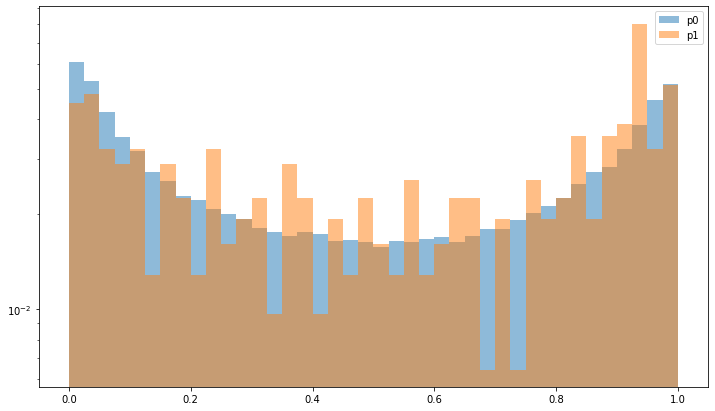

/Users/rurlus/.pyenv/versions/3.8.5/envs/SYNTHSONIC/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
INFO:KDECopulaNNPdf:Maximum weight found: 1.4010193002142814


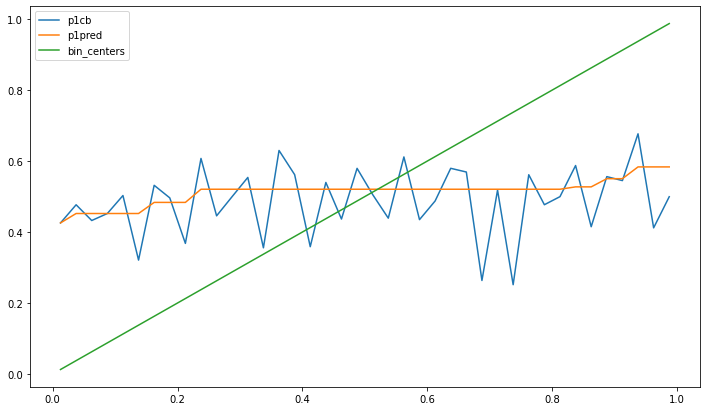

In [23]:
kde._calibrate_classifier(kde.hist_p0_, kde.hist_p1_, kde.bin_edges_, validation_plots=True)

## Check significance

In [24]:
from phik.report import plot_correlation_matrix as phi_plot_correlation_matrix

In [25]:
import scipy

In [26]:
from sklearn.utils import check_array
from sklearn.utils.validation import FLOAT_DTYPES # check_is_fitted, _deprecate_positional_args

## Weighted sample

In [27]:
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

In [28]:
X = df_num.values

In [29]:
X

array([[ 0.    ,  3.    ,  0.    , ...,  1.    ,  0.    ,  7.25  ],
       [ 1.    ,  1.    ,  1.    , ...,  1.    ,  0.    , 71.2833],
       [ 1.    ,  3.    ,  1.    , ...,  0.    ,  0.    ,  7.925 ],
       ...,
       [ 0.    ,  3.    ,  1.    , ...,  1.    ,  2.    , 23.45  ],
       [ 1.    ,  1.    ,  0.    , ...,  0.    ,  0.    , 30.    ],
       [ 0.    ,  3.    ,  0.    , ...,  0.    ,  0.    ,  7.75  ]])

In [30]:
X_bn = kde._transform_and_slice(X, discretize=True)

In [31]:
X_bn

array([[0., 3., 0., ..., 1., 0., 2.],
       [1., 1., 1., ..., 1., 0., 6.],
       [1., 3., 1., ..., 0., 0., 3.],
       ...,
       [0., 3., 1., ..., 1., 2., 8.],
       [1., 1., 0., ..., 0., 0., 7.],
       [0., 3., 0., ..., 0., 0., 1.]])

In [32]:
X_noweight = kde._sample_bayesian_network(size=100*X.shape[0], add_uniform=False)

INFO:KDECopulaNNPdf:Generating 88700 data points.
Generating for node: 5: 100%|██████████| 7/7 [00:00<00:00, 15.22it/s]


In [190]:
kde.nonlinear_indices_

[0, 1, 2, 3, 4, 5, 6]

In [33]:
for i in range(X_noweight.shape[1]):
    print (i, len(np.unique(X_bn[:, i])))

0 2
1 3
2 2
3 10
4 7
5 7
6 10


In [34]:
for i in range(X_noweight.shape[1]):
    print (i, len(np.unique(X_noweight[:, i])))

0 2
1 3
2 2
3 10
4 7
5 7
6 10


In [35]:
X_noweight

array([[0., 3., 0., ..., 0., 0., 0.],
       [0., 2., 1., ..., 0., 0., 1.],
       [1., 2., 1., ..., 1., 1., 4.],
       ...,
       [0., 1., 0., ..., 1., 0., 2.],
       [0., 2., 0., ..., 0., 0., 6.],
       [0., 3., 0., ..., 0., 0., 0.]])

In [36]:
X_weighted = kde.sample_no_weights(n_samples=100*X.shape[0])

In [37]:
X_weighted = kde._transform_and_slice(X_weighted, discretize=True)

In [38]:
X_bn.shape, X_noweight.shape, X_weighted.shape

((887, 7), (88700, 7), (88700, 7))

(array([0.10899411, 0.1120005 , 0.11112364, 0.10628836, 0.11276462,
        0.11061005, 0.11121132, 0.11648503, 0.11042215, 0.11121132]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

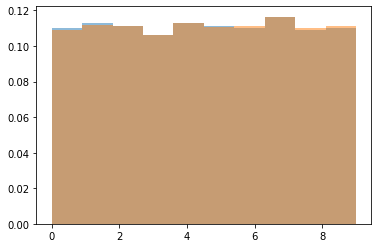

In [39]:
i = 6
plt.hist(X_bn[:, i], bins = 10, density=True, alpha=0.5)
plt.hist(X_noweight[:, i], bins = 10, density=True, alpha=0.5)

In [40]:
X_bn

array([[0., 3., 0., ..., 1., 0., 2.],
       [1., 1., 1., ..., 1., 0., 6.],
       [1., 3., 1., ..., 0., 0., 3.],
       ...,
       [0., 3., 1., ..., 1., 2., 8.],
       [1., 1., 0., ..., 0., 0., 7.],
       [0., 3., 0., ..., 0., 0., 1.]])

In [41]:
X_noweight

array([[0., 3., 0., ..., 0., 0., 0.],
       [0., 2., 1., ..., 0., 0., 1.],
       [1., 2., 1., ..., 1., 1., 4.],
       ...,
       [0., 1., 0., ..., 1., 0., 2.],
       [0., 2., 0., ..., 0., 0., 6.],
       [0., 3., 0., ..., 0., 0., 0.]])

In [42]:
X_weighted

array([[0., 3., 0., ..., 4., 1., 9.],
       [0., 1., 0., ..., 1., 1., 5.],
       [0., 2., 0., ..., 0., 0., 6.],
       ...,
       [1., 3., 1., ..., 0., 0., 5.],
       [0., 2., 1., ..., 0., 0., 4.],
       [0., 3., 0., ..., 0., 0., 2.]])

In [43]:
from synthsonic.models.phik_utils import phik_matrix

In [44]:
pku = phik_matrix(X_bn, X_noweight)
pkw = phik_matrix(X_bn, X_weighted)


28it [00:00, 109.51it/s]
28it [00:00, 111.28it/s]


In [45]:
import phik

In [46]:
from phik.phik import phik_matrix

In [47]:
from phik import phik

In [48]:
from phik import config

In [49]:
df_bn = pd.DataFrame(X_bn)

In [50]:
pkd = df_bn.phik_matrix(interval_cols=[])

In [51]:
pkd

,0,1,2,3,4,5,6
0,1.000000,0.204180,0.749062,0.283591,0.174540,0.145587,0.359746
1,0.204180,1.000000,0.076596,0.722619,0.215666,0.029891,0.219995
2,0.749062,0.076596,1.000000,0.139220,0.191275,0.230240,0.360321
3,0.283591,0.722619,0.139220,1.000000,0.290678,0.165355,0.211729
4,0.174540,0.215666,0.191275,0.290678,1.000000,0.589348,0.472898
5,0.145587,0.029891,0.230240,0.165355,0.589348,1.000000,0.460085
6,0.359746,0.219995,0.360321,0.211729,0.472898,0.460085,1.000000


In [52]:
pku

,0,1,2,3,4,5,6
0,1.000000,0.000000,0.000000,0.0,0.090573,0.069716,0.166475
1,0.000000,1.000000,0.018037,0.0,0.083981,0.223191,0.196880
2,0.000000,0.018037,1.000000,0.0,0.000000,0.098463,0.000000
3,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
4,0.090573,0.083981,0.000000,0.0,1.000000,0.000000,0.000000
5,0.069716,0.223191,0.098463,0.0,0.000000,1.000000,0.000000
6,0.166475,0.196880,0.000000,0.0,0.000000,0.000000,1.000000


In [53]:
pkw

,0,1,2,3,4,5,6
0,1.000000,0.000000,0.000000,0.0,0.086012,0.048649,0.137116
1,0.000000,1.000000,0.030910,0.0,0.078507,0.180534,0.148642
2,0.000000,0.030910,1.000000,0.0,0.000000,0.106759,0.000000
3,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
4,0.086012,0.078507,0.000000,0.0,1.000000,0.000000,0.000000
5,0.048649,0.180534,0.106759,0.0,0.000000,1.000000,0.000000
6,0.137116,0.148642,0.000000,0.0,0.000000,0.000000,1.000000


In [170]:
df = df.rename(columns={'Siblings/Spouses Aboard': 'Sib...Aboard', 'Parents/Children Aboard': 'Par...Aboard'})

In [171]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Sib...Aboard', 'Par...Aboard',
       'Fare'],
      dtype='object')

In [172]:
columns = df.columns.to_list()
columns[3] = '$X_{bn}[0]$'
columns[6] = '$X_{bn}[1]$'

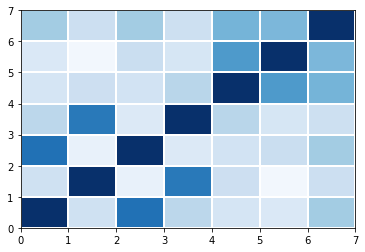

In [173]:
vmin = 0
vmax = 1
color_map = 'Blues'
norm = plt_colors.Normalize(vmin=vmin, vmax=vmax)
img = plt.pcolormesh(pkd.values, cmap=color_map, edgecolor='w', linewidth=1, norm=norm);

In [188]:
pk_or = df.phik_matrix(interval_cols=['Fare', 'Age'])

In [194]:
4.6 * 1.1

5.06

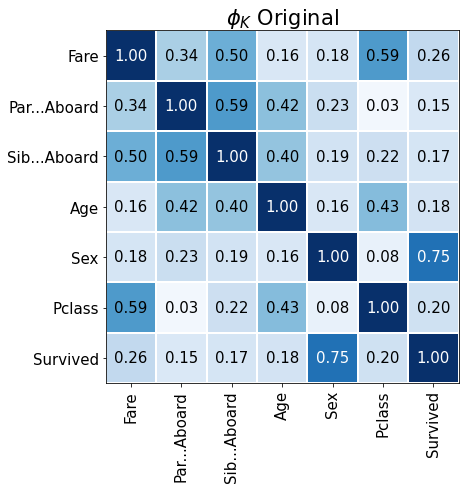

In [189]:
figsize = (7, 7)
rect = [0.2, 0.2, 0.7, 0.7]

fig = plt.figure(figsize=figsize)
ax1 = fig.add_axes(rect)

plot_correlation_matrix(
    pk_or.values,
    fig=fig,
    ax=ax1,
    x_labels=df.columns.to_list(),
    y_labels=df.columns.to_list(), 
    vmin=vmin,
    vmax=vmax,
    color_map=color_map,
    title=r'$\phi_K$ Original',
    fontsize_factor=1.5,
)
#ax1.set_yticklabels(ax1.get_yticklabels(), rotation=45)
fig.savefig(f'{data_set}_phik_original.pdf', dpi=600)

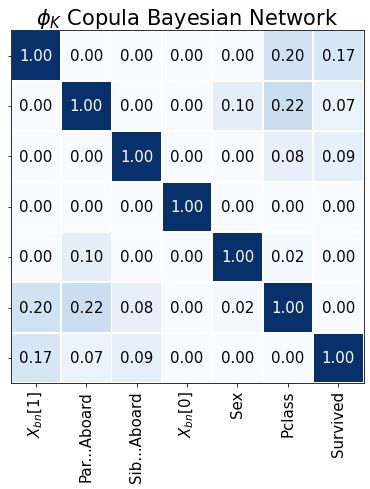

In [175]:
figsize = (7, 7)
rect = [0.2, 0.2, 0.7, 0.7]

fig = plt.figure(figsize=figsize)
ax1 = fig.add_axes(rect)

plot_correlation_matrix(
    pku.values,
    fig=fig,
    ax=ax1,
    x_labels=columns,
    y_labels=columns, 
    vmin=vmin,
    vmax=vmax,
    color_map=color_map,
    title=r'$\phi_K$ Copula Bayesian Network',
    fontsize_factor=1.5,
)
ax1.set_yticklabels([])
fig.savefig(f'{data_set}_phik_copula_bn.pdf', dpi=600)

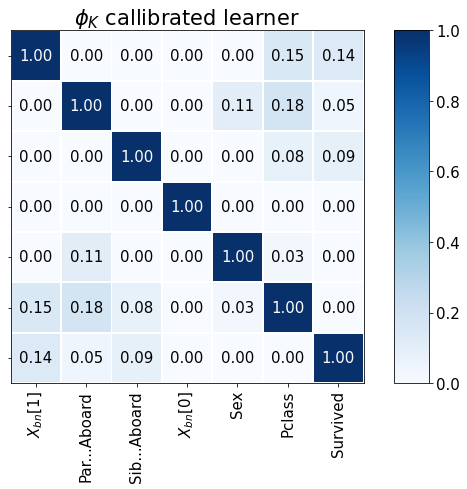

In [192]:
figsize = (7, 7)
rect = [0.2, 0.2, 0.7, 0.7]

fig, ax1, ax2 = split_figure_vertical(figsize, 0.1, rect, [-0.4, 0.2, 0.7, 0.7])
plot_correlation_matrix(
    pkw.values,
    fig=fig,
    ax=ax1,
    x_labels=columns,
    y_labels=columns, 
    vmin=vmin,
    vmax=vmax,
    color_map=color_map,
    title=r'$\phi_K$ callibrated learner',
    fontsize_factor=1.5,
)
ax1.set_yticklabels([])
cb = plt.colorbar(img, cax=ax2, pad=0.01)
cb.ax.tick_params(labelsize=15)
fig.savefig(f'{data_set}_phik_calibrated_learner.pdf', dpi=600)